In [1]:
import numpy as np
from analysis_pipeline import get_data
from analysis_pipeline import process_spikes as spk
from analysis_pipeline import make_plots

import matplotlib.pyplot as plt
from matplotlib import gridspec

from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from tqdm import trange

C:\Users\ilow1\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# file paths
base = 'G:/My Drive/Giocomo Lab/RandomForage/'
data_folder = base + 'aggregate_data/'

# to save figure images, if desired
# save_folder = base + '/figure_folder/'
# supp_save_folder = base + '/figure_folder/'

In [3]:
''' run analysis on 2-map sessions '''
mice = ['Pisa', 'Hanover', 'Calais', # cue poor
        'Seattle',  'Portland', 'Quebec', 'Toronto', 'Vancouver', # cue rich
        'Mumbai', 'Kerala', 'Goa', 'Punjab', 'Salvador'] # cue rich, NP9 = male
mouse_IDs = ['1c', '2a', '3a', '6a', '6b', '7a', '7b', '7c', '9a', ' 9b', '9c', '9d', '10a']
sessions = [['0430_1', '0501_1', '0502_1'], # Pisa
            ['0615_2'], # Hanover
            ['0713_2'], # Calais
            ['1005_1', '1006_1', '1007_1'], # Seattle
            ['1005_2'],  # Portland
            ['1007_1'], # Quebec
            ['1111_1', '1112_1', '1113_1', '1114_1', '1115_1', '1117_1'], # Toronto
            ['1114_1', '1118_1'], # Vancouver
            ['1130_1', '1201_1', '1129_1'], # Mumbai
            ['1207_1'], # Kerala
            ['1211_1', '1210_1', '1209_1'], # Goa
            ['1217_1', '1214_1'], # Punjab
            ['1202_1'] # Salvador
           ]

print('N mice: ' + str(len(mice)))
N_sessions = 0
for s in sessions:
    N_sessions += len(s)
print('N sessions: ' + str(N_sessions))

N mice: 13
N sessions: 28


In [4]:
# make a dict to hold data
data = {}
for session, m in zip(sessions, mice):
    data[m] = {}
    for s in session:
        data[m][s] = {}

In [5]:
# load the data
N_cells = 0
for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        d = data[m][s]
        Y, B, A, cells = get_data.open_files(data_folder + 'gap_corrected/', m, s)
        d['Y'] = Y
        d['B'] = B
        d['A'] = A
        d['cells'] = cells

        # count the total number of cells
        N_cells += d['cells'].shape[0]

Calais_0713_2 corrected for mistargeting
Toronto_1112_1 corrected for mistargeting
Mumbai_1130_1 corrected for mistargeting


In [6]:
# count the number of sessions
N_cue_poor = 0
N_cue_rich = 0
N_sessions = 0

for m, session in zip(mice, sessions):
    N_sessions += len(session)
    if m in ['Milan', 'Pisa', 'Hanover', 'Boston', 'Camden', 'Calais']:
        N_cue_poor += len(session)
    else:
        N_cue_rich += len(session)
        
print(f'N mice = {len(mice)}')
print(f'N sessions = {N_sessions}')
print(f'N cue rich = {N_cue_rich}')
print(f'N cue poor = {N_cue_poor}')
print(f'N cells = {N_cells}')

N mice = 13
N sessions = 28
N cue rich = 23
N cue poor = 5
N cells = 4984


In [7]:
# calculate trial-by-trial similarity
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        Y = d['Y'].copy()
        d['similarity'] = spk.similarity(Y)

In [8]:
''' fit k-means to get map labels for each trial '''
N = 2
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        Y = d['Y'].copy()
        d['kmeans'] = spk.fit_kmeans(Y, n_components=N, n_restarts=100)

In [9]:
# get the index for each trial preceding a remap event
for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        d = data[m][s]
        W = d['kmeans']['W']
        d['remap_idx'] = spk.get_remap_idx(W)

In [10]:
# remap stats
n_remaps = np.zeros(N_sessions)
i = -1
for m, session in zip(mice, sessions):
    for s in session:
        i += 1
        d = data[m][s]
        remap_idx = d['remap_idx']
        n_remaps[i] = remap_idx.shape[0]
        
print(f'total N remaps = {np.sum(n_remaps)}')
print(f'mean, sem: {np.mean(n_remaps):.2f}, {stats.sem(n_remaps):.2f}')
print(f'range: {np.min(n_remaps)} to {np.max(n_remaps)}')

total N remaps = 145.0
mean, sem: 5.18, 1.23
range: 1.0 to 27.0


In [11]:
# get map indices by observation and define map 0 as the slower map
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        A = d['A']
        W = d['kmeans']['W']
        d['idx'], d['map0_idx'] = spk.map_idx_by_obs(A, W)

In [12]:
''' compute within vs. across map similarity '''
all_within = np.asarray([])
all_across = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        sim = d['similarity']
        W = d['kmeans']['W']
        map_0 = W[:, d['map0_idx']].astype(bool)        
        
        # calculate and save for all sessions
        avg_within, avg_across = spk.map_similarity(sim, map_0)
        all_within = np.append(all_within, avg_within)
        all_across = np.append(all_across, avg_across)

In [13]:
# % change in spatial similarity
d_sim = ((all_across - all_within) / all_within) * 100
print(f'mean, sem within map similarity: {np.mean(all_within):.2f}, {stats.sem(all_within):.2f}')
print(f'mean, sem across map similarity: {np.mean(all_across):.2f}, {stats.sem(all_across):.2f}')
print(f'pct change in spatial similarity (mean, sem): {np.mean(d_sim):.2f}%, {stats.sem(d_sim):.2f}%')

mean, sem within map similarity: 0.36, 0.01
mean, sem across map similarity: 0.27, 0.01
pct change in spatial similarity (mean, sem): -25.76%, 2.70%


In [14]:
# significant?
sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(all_within, all_across)
print(f'within map vs across map similarity: p = {sameVSdiff_p}')
print(f'n = {all_within.shape[0]} model pairs')

within map vs across map similarity: p = 3.789619441580871e-06
n = 28 model pairs


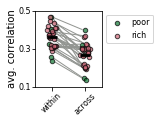

In [15]:
''' Figure 3E: within vs. across map similarity '''
f, ax = make_plots.plot_fig3e(all_within, all_across, N_cue_poor, N_cue_rich)
# f.savefig(save_folder + 'similarity_summary.png', dpi=400, bbox_inches='tight')
plt.show()

In [16]:
''' get distance to k-means cluster on each trial 
see STAR Methods for more details
'''
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        Y = d['Y'].copy()
        H = d['kmeans']['H']
        W = d['kmeans']['W']
        map0_idx = d['map0_idx']
        
        # calculate distance to cluster for full population
        d['dist'] = spk.clu_distance_population(Y, H, map0_idx)
        
        # calculate distance to cluster and log likelihood for each cell
        d['cells_dist'], d['ll_cells'] = spk.clu_distance_cells(Y, H, map0_idx, W)

In [17]:
''' TODO FIX THIS get each good cell's coordinates in MEC '''
hist = np.load(data_folder + '_histology.npy').item()

for m, session in zip(mice, sessions):
    for s in session:
        sp = np.load(data_folder + m + '_' + s + '_spikeInfo.npy').item()
        d = data[m][s]
        d['sp'] = sp
        cells_unfilt = sp['cids'][sp['cgs']==2] # unsorted
        cells = d['cells'] # sorted by depth
        MEC_idx = np.isin(cells_unfilt, cells) # unsorted

        # get probe coordinates
        coords = hist[m][s]['histology']
        tip = coords[0][:-1]
        entry = coords[1]

        # get distance from tip
        depth = sp['spike_depth'].copy() # unsorted
        MEC_depth = np.sort(depth[MEC_idx]) # sort by depth

        # convert to brain coordinates
        cell_coords = spk.get_coordinates(tip, entry, MEC_depth)
        d['cell_coords'] = cell_coords

In [18]:
''' relate anatomical location to distance from cluster '''
DV_coords = np.asarray([])
ML_coords = np.asarray([])
AP_coords = np.asarray([])
avg_ll_cell_all = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        # get remap score for each cell
        avg_ll_cell = np.mean(d['ll_cells'], axis=1)
        avg_ll_cell_all = np.append(avg_ll_cell_all, avg_ll_cell)

        # relate to anatomical location
        cell_coords = d['cell_coords']
        DV_coords = np.append(DV_coords, cell_coords[:, -1])
        ML_coords = np.append(ML_coords, cell_coords[:, 0])
        AP_coords = np.append(AP_coords, cell_coords[:, 1]) 

In [19]:
# compute the % of cells that are remappers in each anatomical bin
DV_pcts, DV_loc = spk.remapper_locations(avg_ll_cell_all, 
                                         DV_coords, min_coord=50, max_coord=2050, 
                                         BIN=50, THRESH=1)
ML_pcts, ML_loc = spk.remapper_locations(avg_ll_cell_all,
                                         ML_coords, min_coord=-200, max_coord=350, 
                                         BIN=50, THRESH=1, print_results=False)
AP_pcts, AP_loc = spk.remapper_locations(avg_ll_cell_all, 
                                         AP_coords, min_coord=50, max_coord=700, 
                                         BIN=50, THRESH=1, print_results=False)

N cells total = 4984
N cells strong remappers = 4108
strong remappers overall = 82.42%


In [20]:
''' Figure 3F: % of all cells that are consistent remappers for different anatomical locations '''
f, gs = make_plots.plot_fig3f(avg_ll_cell_all, DV_pcts, ML_pcts, AP_pcts,
                               DV_loc, ML_loc, AP_loc,
                               THRESH=1)
# f.savefig(save_folder + 'remappers_by_location.png', dpi=400, bbox_inches='tight')
plt.show()

TypeError: plot_fig3f() got multiple values for argument 'THRESH'

In [ ]:
''' Figure 3B: example network-wide similarity, k-means fit, and single cell distance to cluster '''
f, gs = make_plots.plot_fig3b(data)
# f.savefig(save_folder + '{}_{}_similarity.png'.format(m, s), dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
''' Figure 4 - single cell effects '''
pct_dFR = np.asarray([])
all_angles = np.asarray([])
dt = 0.02

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        A = d['A'].copy()
        B = d['B'].copy()
        map0_idx = d['idx']
        map1_idx = ~map0_idx
        
        # get change in peak FR and spatial similarity across maps
        FR_0, binned_pos, FR_0_sem = spk.tuning_curve(A[map0_idx, 0], B[map0_idx, :], dt, b=2, SEM=True)
        FR_1, binned_pos, FR_1_sem = spk.tuning_curve(A[map1_idx, 0], B[map1_idx, :], dt, b=2, SEM=True)
        pct_dFR = np.append(pct_dFR, spk.FR_diff(FR_0, FR_1))
        all_angles = np.append(all_angles, spk.spatial_similarity(FR_0, FR_1))

In [ ]:
# remove nans and convert to dissimilarity
nan_idx = np.isnan(all_angles) | np.isnan(pct_dFR)
all_angles = all_angles[~nan_idx]
pct_dFR = pct_dFR[~nan_idx]
dissim = 1-all_angles

In [ ]:
''' Fig. 4B '''
f, gs = make_plots.plot_fig4b(dissim, pct_dFR)
# f.savefig(save_folder + 'changeFR_vs_dissimilarity.png', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
n_cells_total = pct_dFR.shape[0]
print(f.'N cells = {n_cells_total}')
print(f.'half of all cells show dissimilarity < {np.median(dissim):.3f}')
print('half of all cells show firing rate change of > {np.median(pct_dFR):.3f}%')
n_cells_FR_alone = np.sum((pct_dFR > np.median(pct_dFR)) & (dissim < np.median(dissim)))
print(f'this results in {n_cells_FR_alone} cells that retain their spatial preference, but change their firing rate.')
print(f'({((n_cells_FR_alone/n_cells_total)*100):.2f}% of all cells)')
print(f'still, 5% of cells show large changes in spatial coding (dissimilarity > {np.percentile(dissim, 95):.3f})')

In [ ]:
''' SINGLE SESSION '''
m = 'Pisa'
s = '0430_1'
d = data[m][s]
cells = d['cells']
cell_IDs = [226, 430, 299, 362, 349, 317] # example cells for panels G, H, J, L
print(f'n cells = {cells.shape[0]}')

In [ ]:
# load data
A = d['A']
B = d['B']
dt = 0.02

# get map indices
W = d['kmeans']['W']
map0_idx = d['idx']
map1_idx = ~map0_idx

# get FR by position in each map for all cells   
FR, binned_pos, FR_sem = spk.tuning_curve(A[:, 0], B, dt, b=2, SEM=True)
FR_0, binned_pos, FR_0_sem = spk.tuning_curve(A[map0_idx, 0], B[map0_idx, :], dt, b=2, SEM=True)
FR_1, binned_pos, FR_1_sem = spk.tuning_curve(A[map1_idx, 0], B[map1_idx, :], dt, b=2, SEM=True)

In [ ]:
''' Fig. 4A: examples of remapping cells '''
f, gs = make_plots.plot_fig4a(data, mouse=m, session=s, cell_IDs=cell_IDs,
                               FR_naive=FR, FR_0=FR_0, FR_1=FR_1,
                               FR_sem=FR_sem, FR_0_sem=FR_0_sem, FR_1_sem=FR_1_sem)
# f.savefig(save_folder + m + '_' + s + '_example_rasters.png', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
# get absolute % difference in peak FR
pct_dFR = spk.FR_diff(FR_0, FR_1)

# get dissimilarity
angle = spk.spatial_similarity(FR_0, FR_1)
dissim = 1-angle

In [ ]:
''' Fig. 4C: example session change in firing rate vs. dissimilarity '''
f, ax = make_plots.plot_fig4C(dissim, pct_dFR, cells, cell_IDs)
# f.savefig(save_folder + m + '_' + s + '_delFR_vs_delAngle.png', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
# get SI and shuffle for each map
dt = 0.02
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        A = d['A'].copy()
        B = d['B'].copy()
        map0_idx = d['idx']
        map1_idx = ~map0_idx

        # get SI for each map
        SI_map0 = spk.spatial_info(A[map0_idx, 0], B[map0_idx, :], 2, dt)
        SI_map1 = spk.spatial_info(A[map1_idx, 0], B[map1_idx, :], 2, dt)
        d['SI'] = np.row_stack((SI_map0, SI_map1))

        # get shuffle
        shuff_file = data_folder + 'gap_corrected/' + m + '_' + s + '_SI_shuff.npy'
        if Path(shuff_file).exists():
            d['shuff'] = np.load(shuff_file)
        else:
            SI_map0_shuff = spk.shuffle_SI(A[map0_idx, 0], B[map0_idx, :], 2, dt, n_repeats=1000, max_shift=500)
            SI_map1_shuff = spk.shuffle_SI(A[map1_idx, 0], B[map1_idx, :], 2, dt, n_repeats=1000, max_shift=500)
            d['shuff'] = [SI_map0_shuff, SI_map1_shuff]
            np.save(shuff_file, [SI_map0_shuff, SI_map1_shuff]) 

In [ ]:
# change in spatial info across maps
d_SI = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        SI_map0 = d['SI'][0, :]
        SI_map1 = d['SI'][1, :]     
        d_SI = np.append(d_SI, spk.change_SI(SI_map0, SI_map1))

In [ ]:
print('mean absolute change in SI: ' + str(np.round(np.mean(d_SI), 4)))
print('SEM: ' + str(np.round(stats.sem(d_SI), 4)))

In [ ]:
N_cells_CP = 0
N_cells_CR = 0

# get number of cells in each session
for m, session in zip(mice, sessions):
    for s in session:
        i+=1
        d = data[m][s]
        n_cells = d['cells'].shape[0]
        SI_map0 = d['SI'][0, :]
        n_cells = n_cells - np.sum(SI_map0==0)
        print(m + '_' + s + ': total cells = ' + str(n_cells))

        if m in ['Milan', 'Pisa', 'Hanover', 'Boston', 'Camden', 'Calais']:
            N_cells_CP += n_cells
        elif m in mice[3:]:
            N_cells_CR += n_cells

In [ ]:
print('N cue poor cells = ' + str(N_cells_CP))
print('N cue rich cells = ' + str(N_cells_CR))

In [ ]:
total_cells = np.zeros(N_sessions)
retain = np.zeros(N_sessions) # spatial in both maps
gain = np.zeros(N_sessions) # spatial in one map
neither = np.zeros(N_sessions) # not spatial
N_spatial_cells = np.asarray([])

i = -1
for m, session in zip(mice, sessions):
    for s in session:
        i+=1
        d = data[m][s]
        retain[i], gain[i], neither[i], total_cells[i] = spk.percent_spatial(d)
        
pcts = np.asarray([np.sum(retain), np.sum(gain), np.sum(neither)]) / np.sum(total_cells) * 100

In [ ]:
''' Fig. 4E: % of cells that are spatial '''
f, ax = make_plots.plot_fig4e(pcts, label=False)
# f.savefig(save_folder + 'pct_gain-retain_pie.png', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
''' with labels '''
f, ax = make_plots.plot_fig4e(pcts, label=True)
# f.savefig(save_folder + 'pct_gain-retain_labels.png', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
print(f'N cells = {N_cells}')

In [ ]:
print('mean, sem')
print(f'spatial in both: {(np.mean(retain/total_cells)*100):.2f}, {(stats.sem(retain/total_cells)*100):.2f}')
print(f'spatial in one: {(np.mean(gain/total_cells)*100):.2f}, {(stats.sem(gain/total_cells)*100):.2f}')
print(f'never spatial: {(np.mean(neither/total_cells)*100):.2f}, {(stats.sem(neither/total_cells)*100):.2f}')

In [ ]:
''' Fig. 4F: remap score vs. spatial information
dashed line indicates strong remapper cut-off
'''
f, ax = make_plots.plot_fig4f(data, mice, sessions)
# f.savefig(save_folder + 'remap_score_vs_SI.png', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
''' SINGLE SESSION '''
m = 'Pisa'
s = '0430_1'
d = data[m][s]
cells = d['cells']
cell_IDs = [226, 430, 299, 362, 349, 317] # example cells for panels G, H, J, L

In [ ]:
SI_map0 = d['SI'][0, :].copy()
SI_map1 = d['SI'][1, :].copy()
SI_map0_shuff = d['shuff'][0].copy()
SI_map1_shuff = d['shuff'][1].copy()

In [ ]:
''' Fig. 4D: change in spatial information for an example session '''
f, ax = make_plots.plot_fig4d()
# f.savefig(save_folder + m + '_' + s + '_SI_compare.png', dpi=400, bbox_inches='tight')
plt.show()